In [2]:
from VUSentimentLexiconLight import LexiconSent
import spacy
from sentPrep import lemmaGetter
import re
import json
import pandas as pd

settings_file = 'D:/thesis/settings - nl.json'

#Load all necessary pipelines
lexicon = LexiconSent('nl')
lexicon.negators.add('niet')
nlp = spacy.load('nl_core_news_sm')

#Update spaCy using pattern predicative pipeline to improve lemmas for adjectives
#Note: rule-based for comparative and superlative step are functional, but do not capture exceptions
spacy.tokens.Token.set_extension('lemma',getter = lemmaGetter)

#Set the method that determines sentiment
def getSnippetSentiment(snippet):
    doc = nlp(snippet)
    lemmas = [token._.lemma for token in doc]
    pos_tags = [token.pos_ for token in doc]
    return lexicon.getDocSentiment(lemmas,pos_tags,negatorAction = 'flip')

sentToInt = lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0

In [3]:
#Preparation

#Read settings
settings = json.loads(open(settings_file).read())["settings"]

#Read data
df = pd.read_json(settings['mentions_json'], compression = 'gzip')
df.sort_index(inplace = True)

In [4]:
#Set sentiment
df['SENTIMENT'] = df['TEXT'].apply(lambda x: sentToInt(getSnippetSentiment(x)))

In [9]:
from datetime import datetime
df['DATE_dt'] = df['DATE_dt'].apply(lambda x: datetime.fromtimestamp(x/1000))

TypeError: unsupported operand type(s) for /: 'Timestamp' and 'int'

In [13]:
df['MONTH_dt'][0]

Timestamp('2017-12-01 01:00:00')

In [27]:
df.head()

,DATE_dt,HEADLINE,MATCHES,MEDIUM,PARAGRAPH_NO,TEXT,SENTIMENT,MONTH_dt
0,2017-12-28 01:00:00,Europa is terug,"[Europese Unie, EU]",de Volkskrant,3,"De Europese Unie heeft zich weer opgericht, nu...",1,2017-12-01 01:00:00
1,2017-12-28 01:00:00,Europa is terug,"[EU, EU]",de Volkskrant,6,Voorlopig lijkt het populistische gevaar afgew...,-1,2017-12-01 01:00:00
2,2017-12-28 01:00:00,Europa is terug,"[EU, Europese Unie]",de Volkskrant,8,"Martin Schulz, de nieuwe leider van de Duitse ...",1,2017-12-01 01:00:00
3,2017-12-28 01:00:00,Europa is terug,[Europese Unie],de Volkskrant,11,De onenigheid over het accepteren van asielzoe...,0,2017-12-01 01:00:00
4,2017-12-28 01:00:00,Europa is terug,"[Europese Unie, Europese Unie]",de Volkskrant,12,De Europese Unie moet leren te leven met inter...,1,2017-12-01 01:00:00


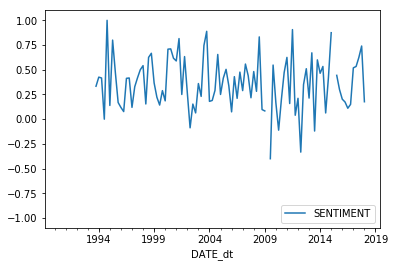

In [48]:
grouped_data = df.groupby(['DATE_dt','HEADLINE','MEDIUM'])
data = grouped_data.mean().reset_index()
grouped_data = data.groupby(pd.Grouper(key = 'DATE_dt',freq='3m'))
del data
grouped_data.mean().reset_index().plot.line(x = 'DATE_dt',y = 'SENTIMENT')